# I. Einführung

Das Notebook dient der Analyse von Kundenabwanderung im Telekommunikationssegment. Der Datensatz entspricht den Kundendaten eines fiktiven Telekommunikationsunternehmens und kann unter https://www.kaggle.com/blastchar/telco-customer-churn abgerufen werden.

# II. Vorbereitung

## 1. Modulimport

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
sns.set()
# Entfernt die Deprecated-Warnungen
warnings.filterwarnings('ignore')

## 2. Daten einladen

In [2]:
raw_data = pd.read_csv("ChurnData.csv")
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Der Datensatz besteht aus 7.043 Zeilen und 21 Attributen:

* Vorherzusagendes Target: Churn
* Numerische Features: Tenure, MonthlyCharges und TotalCharges.
* Kategoriale Features: CustomerID, Gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod.

Nicht alle Datentypen wurden korrekt eingelesen:
- TotalCharges muss ein numerischer Wert sein --> Zu Float konvertieren

In [4]:
# Überprüfung auf Duplikate
raw_data[raw_data.duplicated(keep=False)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Es sind keine Duplikate vorhanden.

## 3. Erste Korrektur von Einlesefehlern

Erste Einlesefehler sollen bereits hier, vor der eigentlichen Data Preparation, behoben werden.

In [5]:
# Total Charges konvertieren
raw_data['TotalCharges'] = pd.to_numeric(raw_data['TotalCharges'], errors='coerce')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Durch die Konvertierung der TotalCharges sind Nullwerte entstanden. Diese Nullwerte müssen korrigiert werden.

In [6]:
# Nullwerte entfernen
# axis = 0 Zeilen / axis = 1 Spalten
data_no_mv = raw_data.dropna(axis=0)

# III. Data Understanding

In diesem Teil des Notebooks sollen mit Hilfe einer explorativen Datenanalyse dem Data Understanding Rechnung getragen werden.

Der Datensatz besteht Nach Entfernung der Nullwerte aus 7032 Zeilen, von denen jeweils eine Zeile einen Kunden beschreibt und 21 Spalten, welche die Attribute der Kunden definieren. Mit Hilfe dieser Daten soll versucht werden zu klassifizieren, ob ein Kunde abspringt oder nicht. Hierzu enthalten die historischen Daten die Zielvariable „Churn“, die Auskunft darüber gibt, ob ein Kunde abgewandert ist. 

## 1. Numerische Attribute

Begonnen wird mit den numerischen Attributen. Zunächst werden die Verteilungen der numerischen Attribute einzeln untersucht und in einem zweiten Schritt werden die kategorischen Attribute in Zusammenhang mit der Zielvariable gesetzt.

In [7]:
# Einladen aller numerischer Attribute
numeric_data = data_no_mv.select_dtypes(include=[np.number])

### 1.1 Tenure

<AxesSubplot:xlabel='tenure', ylabel='Density'>

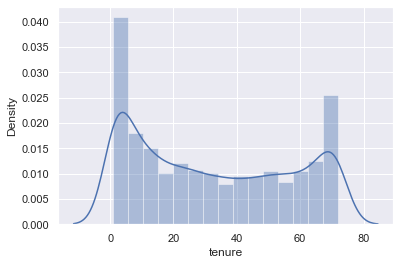

In [8]:
sns.distplot(numeric_data["tenure"])

- Keine Normalverteilung erkennbar. 
- Keine Ausreißer erkennbar.
- Kunden verteilen sich potentiell gleichmäßig über die einzelnen Monate, jedoch ist ein großer Teil der Kunden noch nicht lange dem Unternehmen zugehörig.

<AxesSubplot:xlabel='tenure', ylabel='Density'>

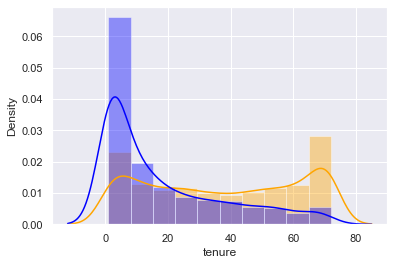

In [9]:
sns.distplot(data_no_mv[data_no_mv.Churn == 'No']["tenure"],
             bins=10,
             color='orange',
             label='Non-Churn',
             kde=True)
sns.distplot(data_no_mv[data_no_mv.Churn == 'Yes']["tenure"],
             bins=10,
             color='blue',
             label='Churn',
             kde=True)

 - Kunden, die noch nicht lange bei dem Unternehmen sind, wandern eher ab als längerfristige Kunden.

### 1.2 Monthly Charges

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Density'>

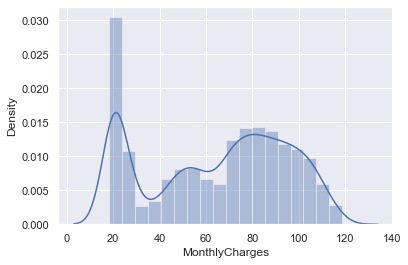

In [10]:
sns.distplot(numeric_data["MonthlyCharges"])

- Keine Normalverteilung erkennbar. 
- Ein Großteil der Kunden ist im vorderen Bereich der Verteilung und zahlt verhältnismäßig geringe monatliche Beiträge.
- Die Kurve verläuft aber trotzdem gleichmäßig mit einem erneutem Anstieg nach hinten und es sind entsprechend keine Ausreißer zu identifizieren.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Density'>

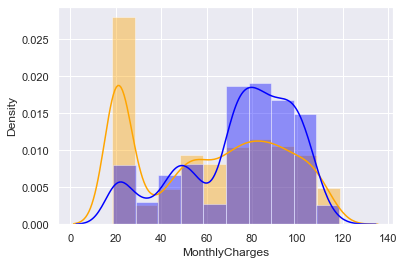

In [11]:
sns.distplot(data_no_mv[data_no_mv.Churn == 'No']["MonthlyCharges"],
             bins=10,
             color='orange',
             label='Non-Churn',
             kde=True)
sns.distplot(data_no_mv[data_no_mv.Churn == 'Yes']["MonthlyCharges"],
             bins=10,
             color='blue',
             label='Churn',
             kde=True)

- Bei Kunden mit niedrigen monatlichen Gebühren ist es wahrscheinlicher, dass sie abwandern. 
- Abwanderungstrend zwischen Kunden, die abwandern und Kunden, die nicht abwandern, wird annährend identisch, wenn die monatlichen Gebühren steigen.

### 1.3 Total Charges

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

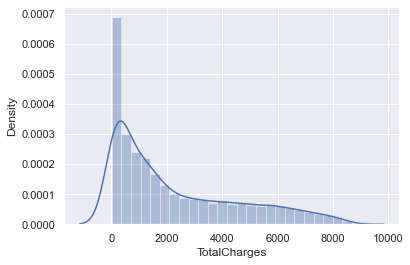

In [12]:
sns.distplot(numeric_data["TotalCharges"])

- Kurve flacht nach hinten extrem stark ab.
- Ähnlichkeiten zur Exponentialverteilung erkennbar. --> Test der logaritschmen Transformation zur Erreichung einer Normalverteilung.
- Es ist fraglich, ob sich im hinteren Teil Ausreißer befinden. --> Boxplot

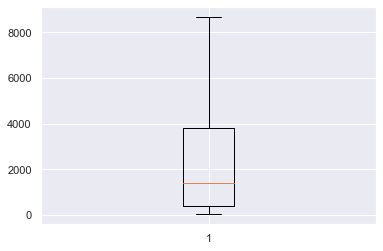

In [13]:
# Boxplot für TotalCharges erstellen, um sicherzustellen, dass keine Ausreißer vorhanden sind.
plt.boxplot(numeric_data["TotalCharges"])
plt.show()

- Der Boxplot zeigt keine Ausreißer.
- Auch für Total Charges lassen sich somit keine Ausreißer erkennen.

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

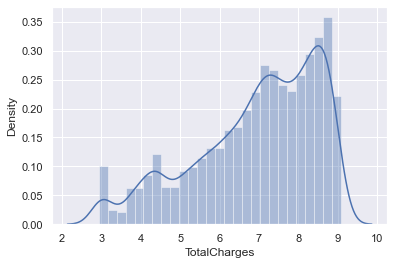

In [14]:
# Versuch der logarithmischen Transformation
log_charges = np.log(data_no_mv["TotalCharges"])
sns.distplot(log_charges)

- Auch die Transformation mit Hilfe des Logarithmus erwirkt keine Normalverteilung. 
- Vor weiteren Transformationen soll zunächst die Korrelation mit anderen Variablen untersucht werden.

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

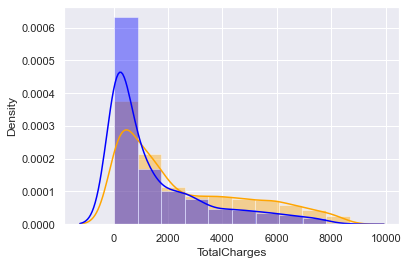

In [15]:
sns.distplot(data_no_mv[data_no_mv.Churn == 'No']["TotalCharges"],
             bins=10,
             color='orange',
             label='Non-Churn',
             kde=True)
sns.distplot(data_no_mv[data_no_mv.Churn == 'Yes']["TotalCharges"],
             bins=10,
             color='blue',
             label='Churn',
             kde=True)

- Die Verteilung ist über die gesamte Bandbreite an Kosten sowohl für Kunden, die abwandern, als auch für Kunden, die nicht abwandern, annährend identisch.


### 1.4 Korrelationsmatrix der numerischen Variablen

<AxesSubplot:>

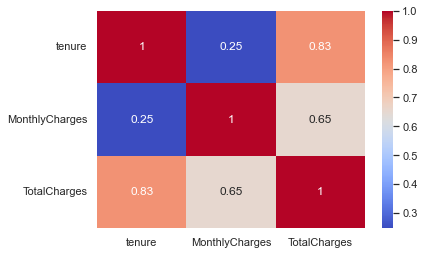

In [16]:
# Korrelation zwischen den numerischen Variablen
feature_corr = numeric_data.drop("SeniorCitizen", axis=1).corr()
sns.heatmap(feature_corr, annot=True, cmap='coolwarm')

Die Korrelationsmatrix zeigt, dass die Attribute "tenure" und "TotalCharges" eine kritische positive Korrelation von über 0,8 aufweisen. Diese Beziehung wird im Rahmen der Multikollinearität später erneut untersucht und muss entfernt werden.

### 1.5 Scatterplots zwischen den numerischen Variablen und der Zielvariable im Vergleich

<AxesSubplot:xlabel='tenure', ylabel='MonthlyCharges'>

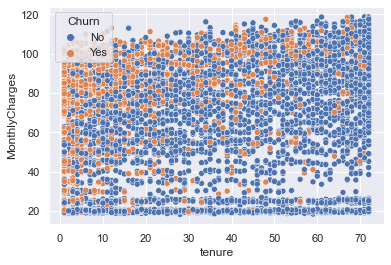

In [17]:
sns.scatterplot(data=data_no_mv, x="tenure", y="MonthlyCharges", hue="Churn")

Der Scatterplot lässt vermuten, dass Kunden im oberen linken Bereich, d.h. Kunden mit hohen monatlichen Kosten und kurzer Unternehmenszugehörigkeit am ehesten abwandern.

<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>

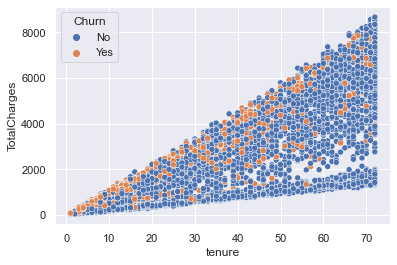

In [18]:
sns.scatterplot(data=data_no_mv, x="tenure", y="TotalCharges", hue="Churn")

Es besteht ein rein logischer, linearer Zusammenhang zwischen der Länge der Unternehmenszugehörigkeit und den gesamten in Rechnung gestellten Kosten. Je länger eine Person Kunde ist, desto mehr Monatsbeträge hat er bereits bezahlen müssen.

## 2. Kategoriale Attribute

Folgend werden die kategorialen Attribute untersucht. Auch hier sollen die Attribute in Zusammenhang mit der Zielvariable gesetzt werden.

## 2.1 Churn (Zielvariable)

Zunächst wird die Verteilung der Zielvariable Churn untersucht.

Text(0.5, 1.0, 'Abwanderung im Vergleich zur Nicht-Abwanderung')

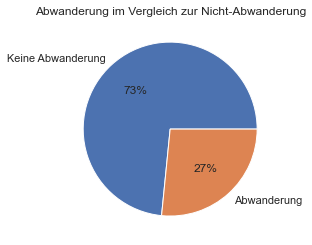

In [19]:
# Kuchendiagramm für Churn erzeugen
# Prozentuale Anteile generieren
churn_rate = data_no_mv.Churn.value_counts() / len(data_no_mv.Churn)

# Plot vorbereiten
labels = 'Keine Abwanderung', 'Abwanderung'
fig, ax = plt.subplots()
ax.pie(churn_rate, labels=labels, autopct='%.f%%')  
ax.set_title('Abwanderung im Vergleich zur Nicht-Abwanderung')

- Abwanderungen entsprechen rund 27% des Gesamtdatensatzes, während nicht-Abwanderungen rund 73% entsprechen.
- Damit handelt es sich um einen unbalancierten Datensatz und eine weitere Metrik muss in der Evaluationsphase verwendet werden.

## 2.2 Gender

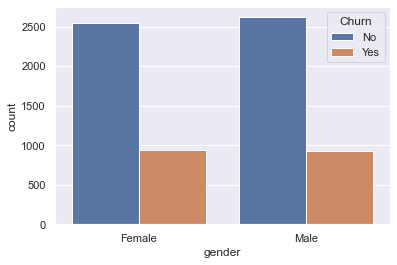

In [20]:
sns.countplot(x="gender", hue="Churn", data=data_no_mv)
plt.show()

Die Abwanderungsrate zwischen männlich und weiblich ist annähernd gleich.

## 2.3 Senior Citizen

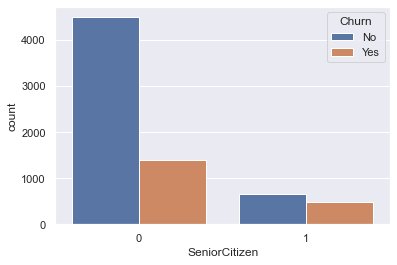

In [21]:
sns.countplot(x="SeniorCitizen", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die als Senioren eingestuft sind, wandern eher ab.

## 2.4 Partner

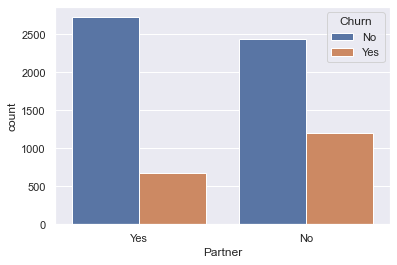

In [22]:
sns.countplot(x="Partner", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die über keinen Partner verfügen, wandern eher ab.

## 2.5 Dependents

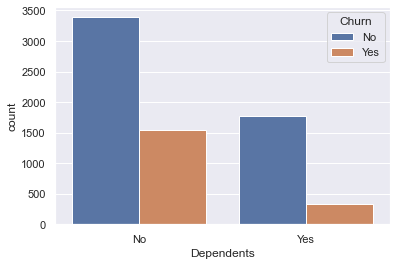

In [23]:
sns.countplot(x="Dependents", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die Angehörige haben, wandern eher ab.

## 2.7 Multiple Lines

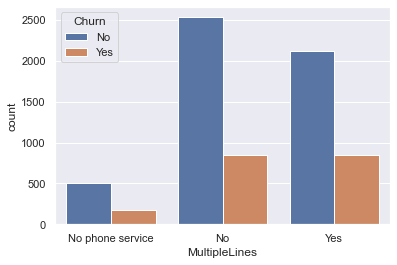

In [24]:
sns.countplot(x="MultipleLines", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die über mehrere Anschlüsse verfügen, wandern eher weniger ab.

## 2.8 Internet Service

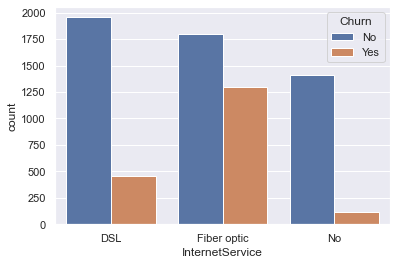

In [25]:
sns.countplot(x="InternetService", hue="Churn", data=data_no_mv)
plt.show()

Wenn ein Kunde über einen Glasfaseroptik Anschluss verfügt, springt er eher ab, als ein Kunde mit DSL.

## 2.9 Online Security

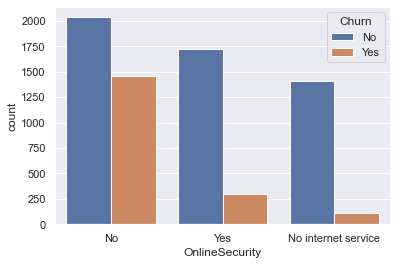

In [26]:
sns.countplot(x="OnlineSecurity", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die den Internet Sicherheitsdienst nicht in Anspruch nehmen, wandern eher ab.

## 2.10 Online Backup

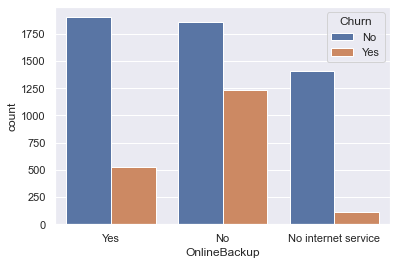

In [27]:
sns.countplot(x="OnlineBackup", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die kein Online Backup verwenden, wandern eher ab.

## 2.11 Device Protection

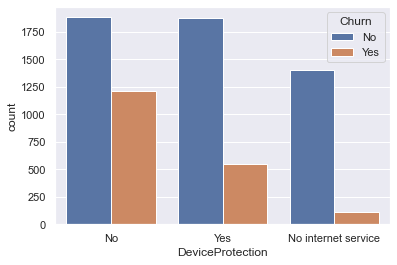

In [28]:
sns.countplot(x="DeviceProtection", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die keinen zusätzlichen Geräteschutz erworben haben, wandern eher ab.

## 2.12 Tech Support

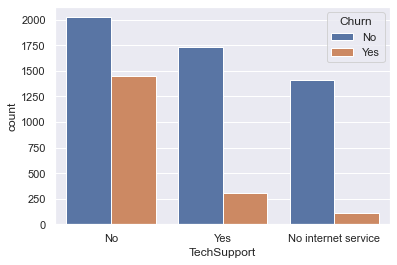

In [29]:
sns.countplot(x="TechSupport", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die keinen Tech Support verwenden, wandern eher ab.

## 2.13 Streaming TV/ Streaming Movies

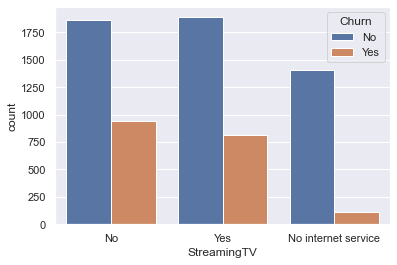

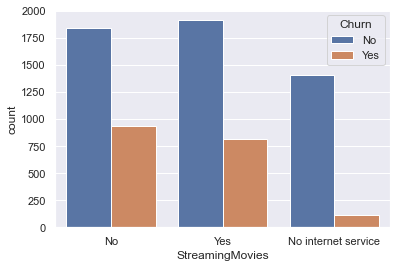

In [30]:
for col in ["StreamingTV", "StreamingMovies"]:
    sns.countplot(x=col, hue='Churn', data=data_no_mv)
    plt.show()

Das Hinzubuchen von Film- und TV Streaming Angeboten hat kaum eine Auswirkung auf die Abwanderungsrate.

## 2.14 Paper less Billing

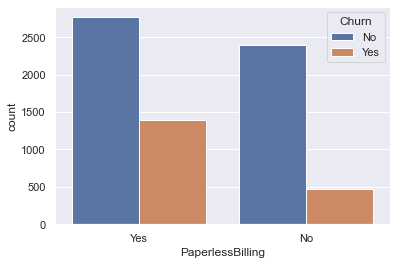

In [31]:
sns.countplot(x="PaperlessBilling", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die ohne Rechnung zahlen, wandern eher ab.

## 2.15 Payment Method

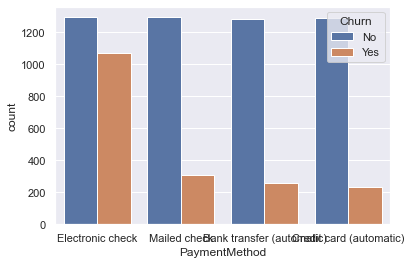

In [32]:
sns.countplot(x="PaymentMethod", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die mittels elektronischem Check zahlen, wandern deutlich öfters ab, als Kunden, die eine andere Zahlungsart verwenden.

## 2.16 Contract

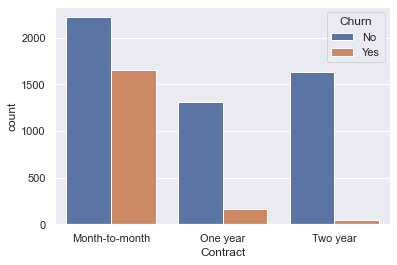

In [33]:
sns.countplot(x="Contract", hue="Churn", data=data_no_mv)
plt.show()

Kunden, die kurzfristiger gebunden sind, wandern eher ab, als Kunden die längerfristige Verträge eingegangen sind.

# IV. Datenpräparation

## 1. Entfernen der Customer ID

In [34]:
# Entfernen der Customer ID, sie liefert keinen Mehrwert für das Modell
data_prep = data_no_mv.drop("customerID", axis = 1)

## 2. Kodierung der kategorischen Variablen

In [35]:
# Binäre Variablen mit Yes und No in 1 und 0 umwandeln
bin_var = ["Partner","Dependents","PhoneService","PaperlessBilling","Churn"]

In [36]:
def binaer_umwandeln(x):
    return x.map({'Yes':1,'No':0})

In [37]:
data_prep[bin_var]=data_prep[bin_var].apply(binaer_umwandeln)
data_prep.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [38]:
# Dummy-Variablen erstellen
data_enc = pd.get_dummies(data_prep, drop_first=True)
data_enc.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,34,1,0,56.95,1889.50,0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,2,1,1,53.85,108.15,1,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,0,42.30,1840.75,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,2,1,1,70.70,151.65,1,0,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# Droppen der Dummies die ebenfalls No phone service und No Internet Service enthalten
dup_variables = ["OnlineSecurity_No internet service","OnlineBackup_No internet service", "TechSupport_No internet service","StreamingTV_No internet service","StreamingMovies_No internet service", "DeviceProtection_No internet service","MultipleLines_No phone service"]
data_enc.drop(dup_variables, axis=1, inplace=True)

## 3. Multikollinearität überprüfen

Um eine korrekte Funktionsweise der spätere Regression zu gewährleisten, darf keine Multikollinearität zwischen den  Variablen vorhanden sein. Das Vorhandensein derselbigen, wird mit Hilfe der Bibliothek Statsmodel überprüft.

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# unabhängige Variablen
vif_test = data_enc.drop("Churn", axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = vif_test.columns 
  
# VIF für jedes Feature 
vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i) 
                          for i in range(len(vif_test.columns))] 
  
print(vif_data)

                                  feature         VIF
0                           SeniorCitizen    1.376564
1                                 Partner    2.824725
2                              Dependents    1.969391
3                                  tenure   20.482153
4                            PhoneService   47.244378
5                        PaperlessBilling    2.956951
6                          MonthlyCharges  212.353073
7                            TotalCharges   21.374002
8                             gender_Male    2.021331
9                       MultipleLines_Yes    2.861614
10            InternetService_Fiber optic   17.695260
11                     InternetService_No    8.234451
12                     OnlineSecurity_Yes    2.682712
13                       OnlineBackup_Yes    2.909898
14                   DeviceProtection_Yes    2.992570
15                        TechSupport_Yes    2.758343
16                        StreamingTV_Yes    4.928957
17                    Stream

"MonthlyCharges" hat den höchsten VIF und wird aus dem Datensatz entfernt.

In [41]:
data_enc.drop("MonthlyCharges", axis=1, inplace=True)

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# unabhängige Variablen
vif_test = data_enc.drop("Churn", axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = vif_test.columns 
  
# VIF für jedes Feature 
vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i) 
                          for i in range(len(vif_test.columns))] 
  
print(vif_data)

                                  feature        VIF
0                           SeniorCitizen   1.366018
1                                 Partner   2.817414
2                              Dependents   1.961947
3                                  tenure  17.073930
4                            PhoneService   9.277446
5                        PaperlessBilling   2.796488
6                            TotalCharges  18.028499
7                             gender_Male   1.942509
8                       MultipleLines_Yes   2.514269
9             InternetService_Fiber optic   4.186492
10                     InternetService_No   3.473225
11                     OnlineSecurity_Yes   1.986701
12                       OnlineBackup_Yes   2.182678
13                   DeviceProtection_Yes   2.299462
14                        TechSupport_Yes   2.099655
15                        StreamingTV_Yes   2.749724
16                    StreamingMovies_Yes   2.771330
17                      Contract_One year   2.

"TotalCharges" hat nun den höchsten VIF und wird aus dem Datensatz entfernt.

In [43]:
data_enc.drop("TotalCharges", axis=1, inplace=True)

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# the independent variables set 
vif_test = data_enc.drop("Churn", axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = vif_test.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i) 
                          for i in range(len(vif_test.columns))] 
  
print(vif_data)

                                  feature       VIF
0                           SeniorCitizen  1.363244
1                                 Partner  2.816895
2                              Dependents  1.956413
3                                  tenure  7.530356
4                            PhoneService  9.260839
5                        PaperlessBilling  2.757816
6                             gender_Male  1.931277
7                       MultipleLines_Yes  2.426699
8             InternetService_Fiber optic  3.581328
9                      InternetService_No  3.321342
10                     OnlineSecurity_Yes  1.947904
11                       OnlineBackup_Yes  2.093763
12                   DeviceProtection_Yes  2.241375
13                        TechSupport_Yes  2.060410
14                        StreamingTV_Yes  2.636855
15                    StreamingMovies_Yes  2.661529
16                      Contract_One year  2.055971
17                      Contract_Two year  3.456061
18  PaymentM

Keine der Variablen hat nun noch einen VIF von über 10.

## 4. Standardisierung der numerischen Variablen

In [45]:
# Zielvariable und Prädiktoren trennen
y = data_enc["Churn"]
X = data_enc.drop(labels = ["Churn"], axis = 1)

In [46]:
# Skalieren der Variablen
from sklearn.preprocessing import StandardScaler
num_features = ['tenure']

scaler = StandardScaler()

X[num_features] = scaler.fit_transform(X[num_features])
X.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,gender_Male,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,-1.280248,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0.064303,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,-1.239504,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0.512486,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,0,0,0,-1.239504,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## 5. Test- und Trainingsdatensatz erstellen

In [47]:
# Daten in Test- und Trainingsdatensatz aufteilen
# Es wird der Default Wert von 80% zu 20% verwendet
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=110)

# V. Modellbildung und Evaluation

## 1. Logistische Regression

Zur Lösung des Problems wird die Logistische Regression eingesetzt. Hierzu werden die beiden Bibliotheken Statsmodels und Scikit-Learn verwendet. Die vollständige Evaluation des Modells erfolgt erst im Unterkapitel zu Scikit-Learn.


## Statsmodels

### 1.1 Training und Vorhersage

In [48]:
# Konstante hinzufügen
X_const = sm.add_constant(X_train)
# Modell erstellen
log_reg = sm.Logit(y_train, X_const).fit() 
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.411450
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5274
Model:                          Logit   Df Residuals:                     5252
Method:                           MLE   Df Model:                           21
Date:                Thu, 12 Oct 2023   Pseudo R-squ.:                  0.2878
Time:                        12:32:13   Log-Likelihood:                -2170.0
converged:                       True   LL-Null:                       -3046.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.3220      

Das trainierte Modell weist statistisch nicht signifikante Variablen aus. Dies ist gegeben wenn der Wert P>|z| größer als 0,05 ist und es sich nicht um die Konstante handelt.

In [49]:
# Entfernen der statistisch nicht signifikanten Features (P>|z|> 0.05)
insignificant_features = ["Partner", "gender_Male", "OnlineBackup_Yes", "DeviceProtection_Yes", "PaymentMethod_Credit card (automatic)","PaymentMethod_Mailed check"]
X_train.drop(insignificant_features, axis=1, inplace=True)
X_test.drop(insignificant_features, axis=1, inplace=True)

Nun kann ein zweites Modell erstellt werden:

In [50]:
# Neues Modell
X_const = sm.add_constant(X_train)
log_reg2 = sm.Logit(y_train, X_const).fit() 
print(log_reg2.summary())

Optimization terminated successfully.
         Current function value: 0.411793
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5274
Model:                          Logit   Df Residuals:                     5258
Method:                           MLE   Df Model:                           15
Date:                Thu, 12 Oct 2023   Pseudo R-squ.:                  0.2872
Time:                        12:32:14   Log-Likelihood:                -2171.8
converged:                       True   LL-Null:                       -3046.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.3536      0.156     -8.661     

Keine statistisch nicht mehr signifikanten Variablen. Das finale Modell wurde modelliert:

In [51]:
# Finales Modell
X_const = sm.add_constant(X_train)
log_reg_final = sm.Logit(y_train, X_const).fit() 
print(log_reg_final.summary())

Optimization terminated successfully.
         Current function value: 0.411793
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5274
Model:                          Logit   Df Residuals:                     5258
Method:                           MLE   Df Model:                           15
Date:                Thu, 12 Oct 2023   Pseudo R-squ.:                  0.2872
Time:                        12:32:14   Log-Likelihood:                -2171.8
converged:                       True   LL-Null:                       -3046.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.3536      0.156     -8.661     

In [52]:
# Vorhersage
y_hat = log_reg_final.predict(sm.add_constant(X_test)) 
# Statsmodel gibt nur die Wahrscheinlichkeiten an, deshalb muss gerundet werden.  
prediction = list(map(round, y_hat))

### 1.3 Evaluation

Zur Evaluation sollen mehrere Metriken verwendet werden, die komfortabler mittels Scikit-Learn erzeugt werden können. Deshalb wird das identische Modell wie mit Statsmodels nochmals in Scikit-Learn erzeugt.

# Scikit-Learn

### 1.1 Training und Vorhersage

In [53]:
from sklearn.linear_model import LogisticRegression
# C wird benötigt um das exakt selbe Modell zu bilden, wie mit Statsmodels; Quelle: https://www.kdnuggets.com/2016/06/regularization-logistic-regression.html
logistic_model = LogisticRegression(random_state=0, C=1e8)

In [54]:
# Vorhersage auf Testdaten
result = logistic_model.fit(X_train,y_train)
prediction_test = logistic_model.predict(X_test)
prediction_train = logistic_model.predict(X_train)

### 1.2 Evaluation

In [55]:
from sklearn import metrics

# Accuracy Score ermitteln
acc = metrics.accuracy_score(y_test, prediction_test)
print('Accuracy auf dem Testdatensatz: {}'.format(acc))

Accuracy auf dem Testdatensatz: 0.8031854379977247


Die Accuracy suggiert ein überdurchschnittlich gutes Modell. Es handelt sich aber um einen unbalancierten Datensatz. Mithin müssen weitere Metriken analysiert werden.

In [56]:
# Klassifikations Report
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


print("Trainingsdaten:")
print(classification_report(y_train,prediction_train))
print("Testdaten:")
print(classification_report(y_test,prediction_test))

Trainingsdaten:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3879
           1       0.66      0.55      0.60      1395

    accuracy                           0.81      5274
   macro avg       0.75      0.72      0.73      5274
weighted avg       0.80      0.81      0.80      5274

Testdaten:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1284
           1       0.68      0.52      0.59       474

    accuracy                           0.80      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758



Höhere Accuracy beim Training als beim Testdatensatz. Insgesamt sind die Werte bei Test- und Trainingsdatensatz sehr ähnlich. Folglich darf nicht von einem Over- bzw. Underfitting ausgegangen werden.

Text(0.5, 39.5, 'Predicted label')

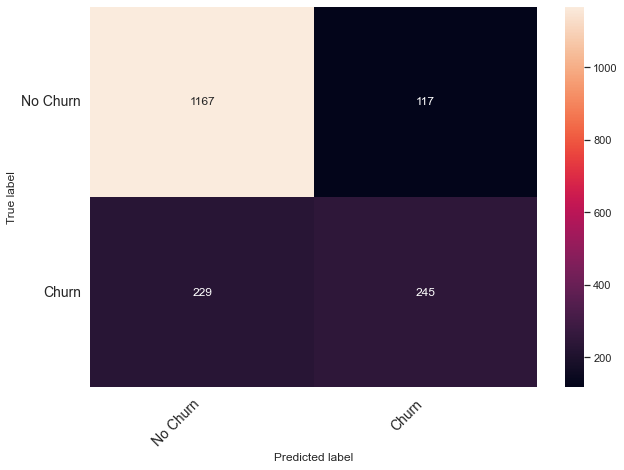

In [57]:
# Confusion-Matrix Testdaten
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,prediction_test)
df_cm = pd.DataFrame(cm, index=['No Churn','Churn'], columns=['No Churn', 'Churn'],)
fig = plt.figure(figsize=[10,7])
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [58]:
# Metriken aus Konfusionsmatrix auslesen 
tn, fp, fn, tp = cm.ravel()
recall = tp/(fn+tp)
precision = tp/(tp+fp)
print("True Negatives: " + str(tn))
print("False Positives: " + str(fp))
print("False Negatives: " + str(fn))
print("True Positives: " + str(tp))
print("Recall: " + str(recall))
print("Precision: " + str(precision))

True Negatives: 1167
False Positives: 117
False Negatives: 229
True Positives: 245
Recall: 0.5168776371308017
Precision: 0.6767955801104972


Precision und Recall bieten ein deutlich realistischeres Bild des Modells. Es erzielt eine Precision von rund 68% und einen Recall von 52%. Der Recall ist für den Anwendungsfall deutlich wichtiger und muss deshalb auf Kosten der Precision verbessert werden.

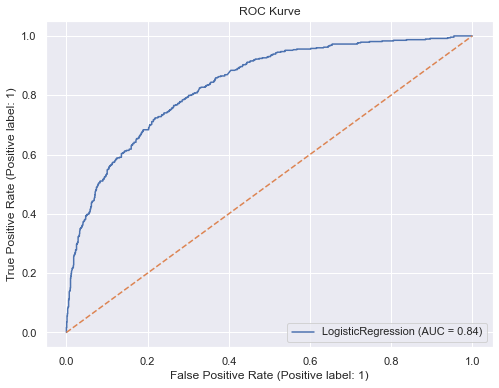

In [59]:
# ROC-Kurve, AUC
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('ROC Kurve')
plot = metrics.plot_roc_curve(logistic_model, X_test, y_test, ax=ax);
ax.plot([0,1], [0,1], '--');

Die AUC der ROC-Kurve liefert einen guten Wert von 0,84. Daraus lässt sich schließen, dass durch Optimierungen des Thresholds Optimierungspotential besteht.

### 1.2.1 Interpretation der Ergebnisse für das Business

Zunächst sollen aber die Ergebnisse für das Business veranschaulicht werden und geklärt werden, welche Kunden zu einer Abwanderung führen und welche gegen eine Abwanderung sprechen.

In [60]:
# Regressionskoeffizienten auslesen und damit Wichtigkeit der einzelnen Attribute herausfinden
weights = pd.Series(logistic_model.coef_[0],
 index=X_train.columns.values)
weights.sort_values(ascending = False)

InternetService_Fiber optic       0.885115
StreamingMovies_Yes               0.328437
PaperlessBilling                  0.318605
MultipleLines_Yes                 0.307473
PaymentMethod_Electronic check    0.303389
SeniorCitizen                     0.259748
StreamingTV_Yes                   0.202215
Dependents                       -0.205691
OnlineSecurity_Yes               -0.307717
TechSupport_Yes                  -0.402906
PhoneService                     -0.533121
Contract_One year                -0.574245
tenure                           -0.914666
InternetService_No               -0.933029
Contract_Two year                -1.315512
dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


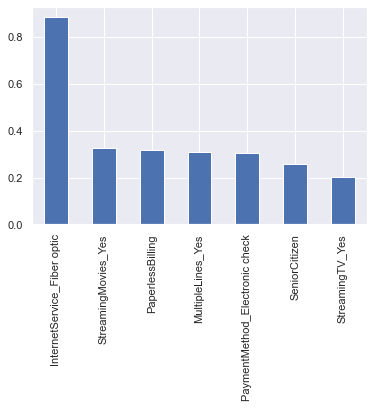

In [61]:
# Grafische Darstellung der wichtigsten Features, die zu einer Abwanderung führen
weights = pd.Series(logistic_model.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:7].plot(kind='bar'))

Die drei wichtigsten Features, die zu einer Abwanderung führen sind:
- Der Glasfaser Dienst (InternetService_Fiber optic),
- die Online-Bezahlungen (PaperlessBilling) und                
- der Bezug des zusätzlichen Film Streamingdienstes (StreamingMovies_Yes)

AxesSubplot(0.125,0.125;0.775x0.755)


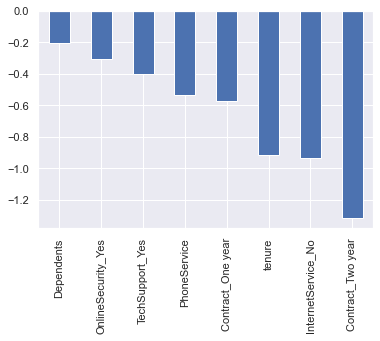

In [62]:
# Wichtigste Features, die Kunden von einer Abwanderung abhalten
print(weights.sort_values(ascending = False)[-8:].plot(kind='bar'))

Die drei wichtigsten Features, die Kunden von einer Abwanderung abhalten sind:
- Die zweijährig kündbaren Verträge (Contract_Two year),
- die Zeit, die Personen bereits Kunden eines Unternehmen sind (Tenure) und                
- kein Bezug des Internetdienstes (InternetService_No).